# **Exploring the Future of Work: Industries Most Affected by AI**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/Data"

Mounted at /content/drive


In [2]:
# import modules & set up logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example
import multiprocessing
from datasets import Dataset
from pandarallel import pandarallel
from collections import Counter, OrderedDict

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import time

import re
import requests
import torch
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

import gensim
from gensim.models import Phrases, LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from umap import UMAP

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/hdbscan/plots.py:448: DeprecationWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.11/dist-packages/hdbscan/robust_single_linkage_.py:154: DeprecationWarning: invalid escape sequence '\{'
  """Perform robust single linkage clustering from a vector array
/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos


> In March of 2023, Goldman Sachs published a report, indicating that ~25% of the tasks in US and Europe can be automated using AI.  However, as you can see in this visualization, not all industries will be affected equally.  According to the report, certain jobs, like office tasks, legal, architecture, and social sciences have a potential for 30%+ automation, while positions like construction, installation, and building maintenance are going to be largely unaffected.

> You can also find supporting evidence in the Facebook Research paper, which highlights Moravec’s Paradox. This thesis posits that the hardest problems in AI involve sensorimotor skills rather than abstract thought or reasoning. Notably, these findings coincide with predictions made by Goldman Sachs.

> For this final project, I have prepared a collection of ~200K news articles on our favorite topics, data science, machine learning, and artificial intelligence. Your task is to identify what industries are going to be most impacted by AI over the next several years, based on the information/insights you can extract from this text corpus.

> Your goal is to provide actionable recommendations on what can be done with AI to automate the jobs, improve employee productivity, and generally make AI adoption successful.  Please pay attention to the introduction of novel technologies and algorithms, such as AI for image generation and Conversational AI, as they represent the entire paradigm shift in adoption of AI technologies and data science in general.

> You can access the data by running the following command in a Jupyter notebook:

In [ ]:
df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
df_news_final_project.shape

(200083, 5)

> Consider the following steps as your brainstorm how you approach this:

> - Become one with the data: read, inspect, and and profile it to understand what you're working with

> - Sanitize the data of web crawl remnants
> - Discard irrelevant articles

> - Detect major topics and draw connections to different industries / jobs
> - Identify top industries / job that experienced successful or unsuccessful AI integration (think sentiment analysis)
>     - Suggest why certain jobs are more likely to be impacted by AI
>     - Plot a timeline to illustrate how sentiment is changing over time

> - Identify technologies and AI solutions that might be affecting the employment landscape
>     - Plot a timeline to illustrate the introduction of some of these technologies
> - Demonstrate what companies, academic institutions, and government entities can do to accelerate the development of these transformative capabilities
> - Leverage appropriate NLP techniques to identify organizations, people, and locations. Then, apply sentiment analysis.
>     - What types of companies are planning to invest in these technologies today or near future (success stories)?
>     - What types of applications cannot by transformed by AI, based on the state of technology (failures)?
>     - Can you provide text extracts / summarizations that support the answers to the above questions?

## **Project Pipeline**

> - **Data PreProcessing:** article clean-up and filtering
> - **Topic Level:**
>   - Topic Modeling: topic detection `Week 3: LDA, NMF, BERTopic, RAKE`
>   - Further Exploration: applying (customized) sentiment analysis to (top) topics + visulization
> - **Entity Level:**
>   - Entity Extraction: extract entity "people, organizations, technologies" using Named Entity Recognization (NER) `Week 7: NER`
>   - Further Exploration: applying sentiment analysis to (top) entities + visualization
> - **Summary + Conclusion**

## **Data Exploration**

> - date: from 2022-1-1 to 2025-4-28, all articles are up-to-date
> - lanague: unique (en), no need to use translation method
> - title: min 6 (OpenAI), max 1387, some failed recognize the title when doing web scraping, but including the body contents
> - text: some articles have too many words (text length is too large, e.g. >100000), while some articles have too few words (e.g. 'Art of AI General\n')
>   - 200000+: 7
>   - 100000~200000: 86
>   - 50000~100000: 617

> Need to filter data by text length because too few words articles mean that the contents do not deliver enough insights (failed to capture web contents or the contents are too "abstract"), while too many words will capture a lot of memories/time for data processing considering these records are not that influential to the final (topic+entity) analysis. --> [Data PreProcessing Part]

In [ ]:
df_news_final_project.head(5)

url  \
0             http://businessnewsthisweek.com/business/infogain-ai-business-solutions-now-available-in-the-microsoft-azure-marketplace/   
1                                                                                       https://allafrica.com/stories/202504250184.html   
2                                                        https://asiatimes.com/2023/07/yang-lan-interviews-academics-on-ai-development/   
3                                         https://cdn.meritalk.com/articles/commerce-nominee-promises-increased-domestic-ai-production/   
4  https://citylife.capetown/hmn/uncategorized/revolutionizing-the-manufacturing-industry-the-impact-of-ai-on-global-production/426638/   

         date language  \
0  2023-05-20       en   
1  2025-04-25       en   
2  2023-07-25       en   
3  2025-02-04       en   
4  2023-11-11       en   

                                                                                                       title  \
0  Infogain AI Business Solutions Now Available in the Microsoft Azure Marketplace | Business News This Week   
1                              Africa: AI Policies in Africa - Lessons From Ghana and Rwanda - allAfrica.com   
2                                               Yang Lan interviews academics on AI development - Asia Times   
3                                      Commerce Nominee Promises Increased Domestic AI Production – MeriTalk   
4                          Revolutionizing the Manufacturing Industry: The Impact of AI on Global Production   

                                                                                                                                                                                                      text  
0  \n\nInfogain AI Business Solutions Now Available in the Microsoft Azure Marketplace | Business News This Week\n\n\r\n\t\t\tBusiness News \n\n \n\n\r\n                        \t[ May 20, 2023 ]    ...  
1  \nAfrica: AI Policies in Africa - Lessons From Ghana and Rwanda - allAfrica.com\nAllAfrica\nEnglish (current)\nEn Français\n\nToggle navigation\nMy Account\nToggle navigation\n\nAllAfrica\nMy Acco...  
2  \nYang Lan interviews academics on AI development - Asia Times\n\n \n\n\t\t\tClose\t\t\n\nSign In \n\n\nSearch for:\n \n\t\t\tSearch\t\t\nChina\nOpinion\n\nOpen dropdown menu\n\n\nChina\nBusiness\...  
3  \nCommerce Nominee Promises Increased Domestic AI Production – MeriTalk\n\n \n\nHome\nNews\nEvents\nResearch\nSponsored Content\n\nAI\nCloud\nCyber\nData\n\n\nOpinion\nLinkedIn\nTwitter\nSearch fo...  
4     Revolutionizing the Manufacturing Industry: The Impact of AI on Global Production    \n  \n\nHla mus rau cov ntsiab lusSat. Nov 11, 2023              Lub neej hauv nroogUnveiling New Technologi...

In [ ]:
min(df_news_final_project["date"]), max(df_news_final_project["date"])

(datetime.date(2022, 1, 1), datetime.date(2025, 4, 28))

In [ ]:
df_news_final_project['language'].unique()

array(['en'], dtype=object)

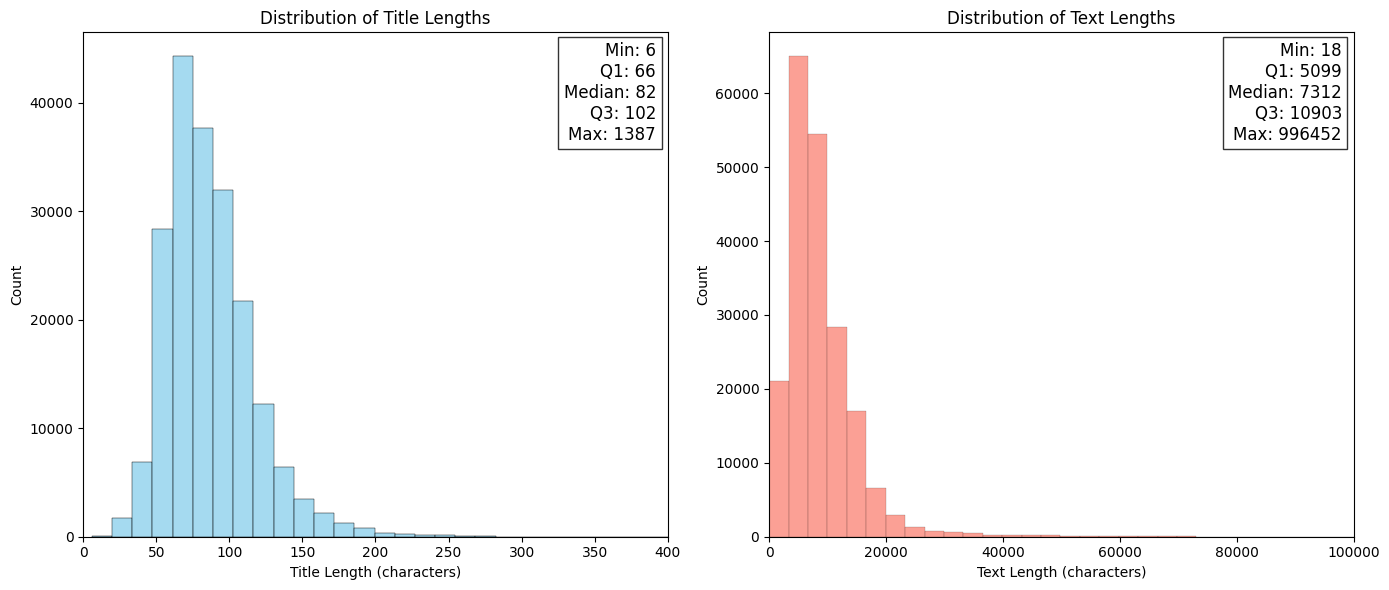

In [ ]:
# Add length columns
df_news_final_project["title_length"] = df_news_final_project["title"].astype(str).apply(len)
df_news_final_project["text_length"] = df_news_final_project["text"].astype(str).apply(len)
title_stats = df_news_final_project["title_length"].describe()
text_stats = df_news_final_project["text_length"].describe()

plt.figure(figsize=(14, 6))

# Title Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(df_news_final_project["title_length"], bins=100, color="skyblue")
plt.title("Distribution of Title Lengths")
plt.xlabel("Title Length (characters)")
plt.ylabel("Count")
plt.xlim(0, 400)  # Set x-axis range

stats_text = "\n".join([
    f"Min: {title_stats['min']:.0f}",
    f"Q1: {title_stats['25%']:.0f}",
    f"Median: {title_stats['50%']:.0f}",
    f"Q3: {title_stats['75%']:.0f}",
    f"Max: {title_stats['max']:.0f}"
])
plt.text(
    0.98, 0.98,              # x, y in axes coords (near top-right)
    stats_text,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8),
    ha='right', va='top',
    transform=plt.gca().transAxes  # Use axes-relative coordinates
)

# Text Length Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_news_final_project["text_length"], bins=300, color="salmon")
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length (characters)")
plt.ylabel("Count")
plt.xlim(0, 100000)  # Set x-axis range to 0–400k

stats_text = "\n".join([
    f"Min: {text_stats['min']:.0f}",
    f"Q1: {text_stats['25%']:.0f}",
    f"Median: {text_stats['50%']:.0f}",
    f"Q3: {text_stats['75%']:.0f}",
    f"Max: {text_stats['max']:.0f}"
])
plt.text(
    0.98, 0.98,              # x, y in axes coords (near top-right)
    stats_text,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.8),
    ha='right', va='top',
    transform=plt.gca().transAxes  # Use axes-relative coordinates
)

plt.tight_layout()
plt.show()


In [ ]:
df_news_final_project[df_news_final_project["title_length"] > 1000]

url  \
38433  https://www.benzinga.com/analyst-ratings/upgrades/22/09/28866199/benzingas-top-ratings-upgrades-downgrades-for-september-14-2022   
75507                                                  https://pop-pr.blogspot.com/2023/07/the-article-is-month-old-hey-i-read-lot.html   

             date language  \
38433  2022-09-14       en   
75507  2023-07-19       en   

                                                                                                                                                                                                         title  \
38433  Netstreit (NYSE:NTST), DICE Therapeutics (NASDAQ:DICE), Shift4 Payments (NYSE:FOUR), Syneos Health (NASDAQ:SYNH), Tennant (NYSE:TNC), SL Green Realty (NYSE:SLG), POINT Biopharma Global (NASDAQ:PNT...   
75507  The article is a month old (hey, I read a lot and sometimes forget to queue up articles to post) but now that it is not just the writers but the actors striking, my guess is that this $3 billion f...   

                                                                                                                                                                                                          text  \
38433  Netstreit (NYSE:NTST), DICE Therapeutics (NASDAQ:DICE), Shift4 Payments (NYSE:FOUR), Syneos Health (NASDAQ:SYNH), Tennant (NYSE:TNC), SL Green Realty (NYSE:SLG), POINT Biopharma Global (NASDAQ:PNT...   
75507  \n\n\nThe article is a month old (hey, I read a lot and sometimes forget to queue up articles to post) but now that it is not just the writers but the actors striking, my guess is that this $3 bil...   

       title_length  text_length  
38433          1387        24817  
75507          1171        10081

In [ ]:
df_news_final_project[df_news_final_project["text_length"] == 18]

url  \
30765   https://www.zeffy.com/en-US/ticketing/5dd4b8a5-0241-4eb3-8d12-7948e44256d0   
171573                                 https://www.toasttab.com/sushi-ai-eureka/v3   
188574        https://www.zeffy.com/ticketing/5dd4b8a5-0241-4eb3-8d12-7948e44256d0   

              date language              title                   text  \
30765   2024-04-11       en  Art of AI General    Art of AI General\n   
171573  2022-06-20       en    Sushi Ai Eureka  \nSushi Ai Eureka\n\n   
188574  2024-04-11       en  Art of AI General    Art of AI General\n   

        title_length  text_length  
30765             17           18  
171573            15           18  
188574            17           18

In [ ]:
sum(df_news_final_project["text_length"] > 50000)

710

## **Data PreProcessing**

> **[Data Filtering]**: Rule-Based: filter out too-short & too-long articles -- 40th percentile ≤ text length < 50000 characters

> **[Article Clean-up]**: Normalizaiton: remove special characters and normalize data using spacy model

> **[Data Filtering]**: Rule-Based: filter out irrelevant articles (such as info not including words like "ai", "artifical intelligence", ...)

In [ ]:
RANDOM_STATE = 42
SPACY_MODEL = "en_core_web_sm"

In [ ]:
data = df_news_final_project.copy()

In [ ]:
data["text_length"].describe()

count    200083.000000
mean       8758.466257
std        7575.064107
min          18.000000
25%        5099.000000
50%        7312.000000
75%       10903.000000
max      996452.000000
Name: text_length, dtype: float64

In [ ]:
# ------ Rule-Based 1 ------
# Filter out articles with too short/long texts
length_threshold = data["text_length"].quantile(0.4)
data = data[
    (data["text_length"] >= length_threshold) &
    (data["text_length"] < 50000)
]
length_threshold

6401.0

In [ ]:
len(data)

119357

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def nltk_clean(text):
    text = re.sub(r"[^a-zA-Z\s]", " ", text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
# simple clearning step
data["text_clean_light"] = data["text"].astype(str).apply(nltk_clean)
data.sample(3)

url  \
191159                                               https://www.geeky-gadgets.com/google-duet-ai-coding-assistant/   
70984                          https://www.wvlt.tv/prnewswire/2023/07/05/ats-acquires-ai-process-optimizer-yazzoom/   
150624  https://www.informnny.com/news/most-adults-think-ai-will-add-to-election-misinformation-in-2024-poll-finds/   

              date language  \
191159  2023-11-02       en   
70984   2023-07-05       en   
150624  2023-11-05       en   

                                                                                title  \
191159  Using Google Duet AI coding assistant to speed up development - Geeky Gadgets   
70984                                       ATS Acquires AI Process Optimizer Yazzoom   
150624   Most adults think AI will add to election misinformation in 2024, poll finds   

                                                                                                                                                                                                           text  \
191159  \nUsing Google Duet AI coding assistant to speed up development - Geeky Gadgets\n \n Skip to main content Skip to secondary menu Skip to primary sidebar Skip to footerGeeky GadgetsThe Latest Techn...   
70984   ATS Acquires AI Process Optimizer Yazzoom\n\nSkip to contentNewsWatch LiveFirst Alert WeatherFirst Alert Live WX CamerasTennessee WaltzAs Seen OnSportsSubmit Photos & VideoHomeNewsLocal NewsNation...   
150624  \n\n \n\n   \n\nMost adults think AI will add to election misinformation in 2024, poll finds\n\nSkip to content\n\n\nWWTI - InformNNY.com\nWatertown\n\n43°\n Sign Up\n\n\nWatertown\n\n43°\n\nSpons...   

        title_length  text_length  \
191159            77         6473   
70984             41        10077   
150624            76        15154   

                                                                                                                                                                                               text_clean_light  
191159  using google duet ai coding assistant speed development geeky gadget skip main content skip secondary menu skip primary sidebar skip footergeeky gadgetsthe latest technology newshome apple android...  
70984   at acquires ai process optimizer yazzoom skip contentnewswatch livefirst alert weatherfirst alert live wx camerastennessee waltzas seen onsportssubmit photo videohomenewslocal newsnationalwatch wv...  
150624  adult think ai add election misinformation poll find skip content wwti informnny com watertown sign watertown sponsored toggle menu open navigation close navigation search please enter search term...

In [ ]:
# ------ Rule-Based 2 ------
# Initial filter: title + text doesn't include ai-related words
keywords = ["ai", "artificial intelligence", "machine learning", "deep learning", "chatgpt", "neural network", "llm", "language model", "nlp", "lanague processing", "robot", "autonomous"]

def contains_ai_terms(text):
    return any(kw in text.lower() for kw in keywords)

data = data[data["text_clean_light"].apply(contains_ai_terms)]
data.head(3)

url  \
1                                                   https://allafrica.com/stories/202504250184.html   
3     https://cdn.meritalk.com/articles/commerce-nominee-promises-increased-domestic-ai-production/   
7  https://digitalmediawire.com/2024/10/08/meta-debuts-new-generative-ai-tools-for-video-based-ads/   

         date language  \
1  2025-04-25       en   
3  2025-02-04       en   
7  2024-10-09       en   

                                                                           title  \
1  Africa: AI Policies in Africa - Lessons From Ghana and Rwanda - allAfrica.com   
3          Commerce Nominee Promises Increased Domestic AI Production – MeriTalk   
7   Meta Debuts New Generative AI Tools For Video-Based Ads | Digital Media Wire   

                                                                                                                                                                                                      text  \
1  \nAfrica: AI Policies in Africa - Lessons From Ghana and Rwanda - allAfrica.com\nAllAfrica\nEnglish (current)\nEn Français\n\nToggle navigation\nMy Account\nToggle navigation\n\nAllAfrica\nMy Acco...   
3  \nCommerce Nominee Promises Increased Domestic AI Production – MeriTalk\n\n \n\nHome\nNews\nEvents\nResearch\nSponsored Content\n\nAI\nCloud\nCyber\nData\n\n\nOpinion\nLinkedIn\nTwitter\nSearch fo...   
7   \n\nMeta Debuts New Generative AI Tools For Video-Based Ads | Digital Media Wire\n\n \n\nmusic\nmobile\nvideo\ngames\nmarketing\nsocial\nVR/AR\nbrands\nrights tech\n \n\n\n \n\nSearch\n\nHome\nOu...   

   title_length  text_length  \
1            77         8982   
3            69        15559   
7            76         6502   

                                                                                                                                                                                          text_clean_light  
1  africa ai policy africa lesson ghana rwanda allafrica com allafrica english current en fran ai toggle navigation account toggle navigation allafrica account english current en fran ai africa ai po...  
3  commerce nominee promise increased domestic ai production meritalk home news event research sponsored content ai cloud cyber data opinion linkedin twitter search menu detail andrew rice feb pm com...  
7  meta debut new generative ai tool video based ad digital medium wire music mobile video game marketing social vr ar brand right tech search home story publishing event contact sign welcome log acc...

In [ ]:
len(data)

119354

## Topic Level

### Zero-Shot Classification

In [ ]:
industry_labels = [
    "Administrative Services: clerical, office management, scheduling, administrative tasks",
    "Agriculture & Environment: farming, sustainability, climate change, natural resources",
    "Business & Finance: banking, stock, market, investment, corporate finance",
    "Communication Services: telecom, internet, digital communication, mobile networks",
    "Construction & Trades: building, carpentry, plumbing, electrical work, renovation",
    "Education: schools, teaching, learning, academia, training",
    "Engineering & Sciences: engineering, research, innovation, R&D, technology development",
    "Government & Politics: public policy, legislation, governance, political systems",
    "Healthcare: hospital, medical, patient care, treatment, clinical services",
    "Hospitality & Food Services: restaurant, catering, hotel, food service, tourism",
    "Legal Services: law, courts, attorneys, legal advice, contracts",
    "Materials: mining, raw materials, metals, manufacturing inputs",
    "Media & Entertainment: film, TV, publishing, content creation, social media",
    "Operations & Maintenance: logistics, facility management, repair, technical operations",
    "Public Services: emergency services, public health, community programs, social services",
    "Real Estate: housing, property, real estate market, construction, leasing",
    "Retail & Commerce: shopping, sales, e-commerce, consumer goods, merchandising",
    "Security & Protection: cybersecurity, surveillance, defense, law enforcement",
    "Technology: software, AI, machine learning, digital tools, IT",
    "Transportation & Logistics: shipping, delivery, transit, supply chain, freight",
    "Utilities: electricity, water, energy, infrastructure, power grid"
]

In [ ]:
def get_abstract(text, max_words):
    words = text.split()
    return " ".join(words[:max_words])

data["text_abstract"] = data["text_clean_light"].astype(str).apply(lambda x: get_abstract(x, max_words=100))

In [ ]:
BATCH_SIZE = 512

In [ ]:
# Load zero-shot classification model on GPU (device=0)
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", device=0)

# Convert DataFrame to a Hugging Face Dataset
hf_data = Dataset.from_pandas(data[["text_abstract"]].astype(str))

# Define a wrapper function that returns a dict
def classify_batch(batch):
    results = classifier(batch["text_abstract"], industry_labels, multi_label=False)
    # Extract top label and score for each item in the batch
    top_labels = [r["labels"][0] for r in results]
    top_scores = [r["scores"][0] for r in results]
    return {"predicted_label": top_labels, "predicted_score": top_scores}

# Apply the classifier in batches
hf_data = hf_data.map(classify_batch, batched=True, batch_size=BATCH_SIZE)

Device set to use cuda:0


Map:   0%|          | 0/119354 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
data["predicted_label"] = hf_data["predicted_label"]
data[["zero_shot_label", "zero_shot_label_description"]] = data["predicted_label"].str.split(": ", n=1, expand=True)
data["zero_shot_score"] = hf_data["predicted_score"]
data.sample(10)

url  \
96151              https://www.einpresswire.com/article/626341952/newly-published-study-demonstrates-the-clinical-effectiveness-of-machine-learning-used-to-achieve-remission-in-patients-with-peanut-allergies   
17524                                                         https://www.thehindubusinessline.com/markets/stock-markets/sonata-software-integrates-its-ai-solution-with-microsoft-azure-ai/article67927950.ece   
187960  https://www.wfmz.com/news/pr_newswire/pr_newswire_health/global-telehealth-telemedicine-markets-2022-2027---opportunities-in-use-of-blockchain-ai-and/article_d777cd51-2bb0-5309-8de0-0e365291696c.html   
64613                                                                         https://itbusinessnet.com/2022/03/inspur-information-ai-servers-to-fully-support-the-newly-announced-nvidia-h100-tensor-core-gpu/   
2759                                                                                                        https://www.nbcnews.com/tech/innovation/chatgpt-gpt-4-gpt4-openai-access-microsoft-how-to-rcna75116   
181359                                                                                                https://goodmenproject.com/featured-content/authors-take-on-tech-giant-openai-for-copyright-infringement/   
154943                                                             https://cio.economictimes.indiatimes.com/amp/news/artificial-intelligence/cadence-to-sell-ai-supercomputer-for-jet-design-software/107343403   
178041                                                                           https://www.livemint.com/ai/over-70-of-indian-retailers-plan-to-adopt-gen-ai-over-next-12-months-ey-survey-11705563040630.html   
82938                                                                                         https://www.computerweekly.com/news/366580493/Embedded-World-2024-Micron-unveils-platforms-to-power-in-vehicle-AI   
145769                                                                                          https://www.trailtimes.ca/trending-now/teachers-turn-to-ai-to-make-workload-more-manageable-chart-lesson-plans/   

              date language  \
96151   2023-04-06       en   
17524   2024-03-08       en   
187960  2022-04-12       en   
64613   2022-03-22       en   
2759    2023-03-17       en   
181359  2023-12-05       en   
154943  2024-02-02       en   
178041  2024-01-18       en   
82938   2024-04-11       en   
145769  2023-08-28       en   

                                                                                                                                                       title  \
96151      Newly Published Study Demonstrates the Clinical Effectiveness of Machine Learning Used to Achieve Remission in Patients with Peanut Allergies       
17524                                                         \tSonata Software integrates its AI solution with Microsoft Azure AI - The Hindu BusinessLine    
187960    Global Telehealth & Telemedicine Markets, 2022-2027 - Opportunities in Use of Blockchain, Ai and Analytics, & Virtual Assistants | News | wfmz.com   
64613                                       Inspur Information AI Servers to Fully Support the Newly Announced NVIDIA H100 Tensor Core GPU – IT Business Net   
2759                                                                                        GPT-4 and OpenAI have shifted the direction of these 5 companies   
181359                                                                   Authors Take on Tech Giant OpenAI for Copyright Infringement - The Good Men Project   
154943                                                                            Cadence to sell AI supercomputer for jet design software, CIO News, ET CIO   
178041                                                               Over 70% of Indian retailers plan to adopt Gen AI over next 12 months: EY survey | Mint   
82938                                                                 Embedded World 2024: Micron un

In [ ]:
# data.to_csv(os.path.join(output_dir, "data_with_labels.csv"), index=False)

### LDA

In [ ]:
normalized_corpus = data['text_clean_light'].apply(lambda x: x.split()).tolist()

# training the phrases to find bigrams
bigram_phraser = Phrases(normalized_corpus) # this might require some eda, to decide min_count

# adding bigrams to the original unigram data
for idx in range(len(normalized_corpus)):
    for phrase in bigram_phraser[normalized_corpus[idx]]:
        if '_' in phrase:
            # phrase is a bigram, add to document.
            normalized_corpus[idx].append(phrase)

In [ ]:
# a dictiohary is the mapping of an id to a word
dictionary = Dictionary(normalized_corpus)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=0.01*len(normalized_corpus), no_above=0.5)

In [ ]:
[(token, idx) for token, idx in dictionary.token2id.items()][:10]

[('ability', 0),
 ('academic', 1),
 ('access', 2),
 ('accessibility', 3),
 ('account', 4),
 ('accountability', 5),
 ('accountable', 6),
 ('actor', 7),
 ('add', 8),
 ('address', 9)]

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in normalized_corpus]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 8442
Number of documents: 119354


In [ ]:
num_topics = 10 # the number of topics we want the model to return
chunksize = 2000 # number of documents to be used in each training chunk
passes = 10 # epochs
iterations = 100 # how many times the model iterates over each document during a single pass / epoch
eval_every = 0  # affects speed and quality of the model, can increase for larger datasets

model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    chunksize=chunksize,
    alpha="auto",
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=RANDOM_STATE
)

In [ ]:
model.show_topics(num_words=20)

[(0,
  '0.009*"ment" + 0.009*"consumer" + 0.009*"overviewview" + 0.008*"general" + 0.007*"resource" + 0.007*"health" + 0.007*"entertain" + 0.006*"financial" + 0.006*"cision" + 0.005*"computer" + 0.005*"transportation" + 0.005*"energy" + 0.005*"culture" + 0.005*"people_culture" + 0.005*"interest" + 0.005*"travel" + 0.005*"manufacturing" + 0.004*"natural" + 0.004*"sport" + 0.004*"send"'),
 (1,
  '0.030*"stock" + 0.015*"nasdaq" + 0.011*"price" + 0.008*"investor" + 0.008*"symbol" + 0.007*"trading" + 0.007*"fund" + 0.007*"index" + 0.006*"investment" + 0.005*"financial" + 0.005*"portfolio" + 0.005*"etf" + 0.005*"buy" + 0.005*"nvidia" + 0.005*"earnings" + 0.005*"crypto" + 0.005*"add" + 0.005*"growth" + 0.004*"analyst" + 0.004*"inc"'),
 (2,
  '0.014*"research" + 0.011*"global" + 0.011*"growth" + 0.008*"size" + 0.007*"analysis" + 0.007*"uae" + 0.007*"currency" + 0.007*"stock" + 0.007*"press" + 0.006*"trend" + 0.006*"asia" + 0.006*"europe" + 0.006*"africa" + 0.005*"menafn" + 0.005*"energy" + 0.0

In [ ]:
model.get_document_topics(corpus[1])

[(5, 0.23470965), (7, 0.56871635), (8, 0.10641608), (9, 0.08987198)]

In [ ]:
# Step 1: Get document-topic distributions
doc_topic_dists = model.get_document_topics(corpus, minimum_probability=0.0)

# Step 2: Extract dominant topic per document
lda_topics = [max(doc, key=lambda x: x[1])[0] for doc in doc_topic_dists]

# Step 3: Add to your dataframe
data["lda_topic"] = lda_topics

In [ ]:
# Group zero-shot labels by LDA topic
grouped = data.groupby("lda_topic")["zero_shot_label"]

custom_labels = {}

for topic_id, labels in grouped:
    label_counts = Counter(labels)
    total = sum(label_counts.values())

    top_labels = label_counts.most_common(2)
    label_str = " | ".join([f"{label} ({int(100 * count / total)}%)" for label, count in top_labels])

    custom_labels[topic_id] = label_str

In [ ]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# display
pyLDAvis.display(vis_data)

In [ ]:
# pyLDAvis.save_html(vis_data, os.path.join(output_dir, 'lda_visualization.html'))

In [ ]:
vis_data[0]["zero-shot-classification"] = vis_data[0].index.map(custom_labels)
vis_data[0]

x         y  topics  cluster       Freq  \
topic                                                   
9     -0.141238 -0.002487       1        1  18.767528   
8      0.038160  0.075988       2        1  17.090852   
5     -0.020408  0.024561       3        1  14.367833   
4     -0.163654 -0.108515       4        1  14.302918   
6     -0.142508  0.030507       5        1   8.632755   
1     -0.046552  0.171322       6        1   7.465272   
7     -0.118900 -0.161412       7        1   5.995668   
0      0.210528  0.116660       8        1   5.661836   
3      0.272200 -0.221871       9        1   4.114116   
2      0.112371  0.075246      10        1   3.601222   

                                              zero-shot-classification  
topic                                                                   
9                       Media & Entertainment (46%) | Technology (31%)  
8                       Media & Entertainment (41%) | Technology (24%)  
5                       Media & Entertainment (33%) | Technology (29%)  
4                        Media & Entertainment (73%) | Healthcare (9%)  
6                       Media & Entertainment (49%) | Technology (28%)  
1                          Technology (24%) | Business & Finance (16%)  
7                       Media & Entertainment (44%) | Healthcare (18%)  
0      Transportation & Logistics (81%) | Communication Services (14%)  
3                                   Education (34%) | Healthcare (20%)  
2                       Media & Entertainment (62%) | Technology (12%)

### Sentiment Analysis

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load sentiment analysis model + tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

def compute_sentiment_score(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(**tokens).logits
    probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    sentiment_score = np.dot(probs, [-1, 0, 1])
    labels = ["Negative", "Neutral", "Positive"]
    top_label = labels[np.argmax(probs)]
    return top_label, sentiment_score, probs

tqdm.pandas()
data[["sentiment_label", "sentiment_score", "prob_distribution"]] = data["text_clean_light"].progress_apply(
    lambda x: pd.Series(compute_sentiment_score(x))
)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

  0%|          | 14/119354 [00:01<1:49:11, 18.21it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

100%|██████████| 119354/119354 [1:10:16<00:00, 28.31it/s]


In [ ]:
# # Load FinBERT model and tokenizer
# model_name = "ProsusAI/finbert"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
# model.eval()

# # Define scoring function with raw logits + softmax
# def compute_finbert_sentiment(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
#     with torch.no_grad():
#         logits = model(**inputs).logits
#     probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()

#     # Label mapping (FinBERT uses this order: [negative, neutral, positive])
#     labels = ["Negative", "Neutral", "Positive"]
#     sentiment_score = np.dot(probs, [-1, 0, 1])
#     top_label = labels[np.argmax(probs)]

#     return top_label, sentiment_score, probs

# # Apply with progress bar
# tqdm.pandas()
# data[["sentiment_label", "sentiment_score", "prob_distribution"]] = data["text_clean_light"].progress_apply(
#     lambda x: pd.Series(compute_finbert_sentiment(x))
# )

In [ ]:
# # Load model
# model_name = "siebert/sentiment-roberta-large-english"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# def compute_siebert_sentiment(text):
#     inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
#     with torch.no_grad():
#         logits = model(**inputs).logits
#     probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
#     score = np.dot(probs, [-1, 1])  # binary: negative=0, positive=1
#     label = "Positive" if score > 0 else "Negative"
#     return label, score, probs

# tqdm.pandas()
# data[["sentiment_label", "sentiment_score", "prob_distribution"]] = data["text_clean_light"].progress_apply(
#     lambda x: pd.Series(compute_siebert_sentiment(x))
# )

In [ ]:
data["sentiment_label"].value_counts(normalize=True)

sentiment_label
Neutral     0.992376
Negative    0.004910
Positive    0.002715
Name: proportion, dtype: float64

In [25]:
print("P(sentiment_score ≥ 0): {}\nP(sentiment_score < 0): {}".format(
    (data["sentiment_score"] >= 0).sum() / len(data), (data["sentiment_score"] < 0).sum() / len(data)))

P(sentiment_score ≥ 0): 0.3342493758064246
P(sentiment_score < 0): 0.6657506241935754


In [ ]:
# data.to_csv(os.path.join(output_dir, "data_with_labels.csv"), index=False)

In [5]:
data["month"] = pd.to_datetime(data["date"]).dt.to_period("M").dt.to_timestamp()

top_5_labels = data["zero_shot_label"].value_counts().head(5).index.tolist()

data_top5 = data[data["zero_shot_label"].isin(top_5_labels)]
data_top5 = data_top5.sort_values("month")
data_top5["Year-Month"] = data_top5["month"].dt.strftime("%Y-%m")

grouped_df = data_top5.groupby(["zero_shot_label", "month"]).agg(
    avg_sentiment=("sentiment_score", "mean")
).reset_index()

In [ ]:
# Step 2: Group by month, industry, and sentiment label
summary_df = (
    data_top5
    .groupby(["Year-Month", "zero_shot_label", "sentiment_label"])
    .size()
    .reset_index(name="count")
)

# Step 3: Ensure every month has all combinations of (industry, sentiment)
all_months = sorted(data_top5["Year-Month"].unique())
sentiment_order = ["Negative", "Neutral", "Positive"]

full_index = pd.MultiIndex.from_product(
    [all_months, top_5_labels, sentiment_order],
    names=["Year-Month", "zero_shot_label", "sentiment_label"]
)

summary_df_full = (
    summary_df
    .set_index(["Year-Month", "zero_shot_label", "sentiment_label"])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

# Step 4: Plot
fig = px.bar(
    summary_df_full,
    x="zero_shot_label",
    y="count",
    color="sentiment_label",
    animation_frame="Year-Month",
    category_orders={
        "zero_shot_label": top_5_labels,
        "sentiment_label": sentiment_order
    },
    labels={
        "zero_shot_label": "Industry",
        "count": "Number of Mentions",
        "sentiment_label": "Sentiment"
    },
    title="Sentiment Category Counts Over Time by Industry",
    text="count"
)

# Layout adjustments
fig.update_layout(
    barmode="stack",
    template="plotly_white",
    xaxis_title="Industry",
    yaxis_title="Article Count",
    legend_title="Sentiment",
    yaxis=dict(range=[0, 3100])
)

# Position the count text in the center of each segment
fig.update_traces(textposition="inside")  # Alternatives: 'outside', 'auto', 'inside'

fig.update_layout(
    updatemenus=[{
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True}],
                "label": "▶",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                "label": "⏹",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 70},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }],
    sliders=[{
        "pad": {"b": 10},
        "currentvalue": {
            "visible": True,
            "prefix": "Year-Month=",
            "xanchor": "right",
            "font": {"size": 14}
        },
        "steps": [{
            "args": [[frame.name], {"frame": {"duration": 1000, "redraw": True}, "mode": "immediate"}],
            "label": frame.name,
            "method": "animate"
        } for frame in fig.frames]
    }]
)

fig.show()

In [ ]:
# fig.write_html(os.path.join(output_dir, "sentiment_by_industry_over_time.html"))

In [ ]:
grouped_df["month"] = pd.to_datetime(grouped_df["month"], errors="coerce").dt.to_period("M").astype(str)
grouped_df = grouped_df.sort_values(by="month")

fig = px.line(
    grouped_df,
    x="month",
    y="avg_sentiment",
    color="zero_shot_label",
    line_group="zero_shot_label",
    markers=True,
    title="Sentiment Trends Over Time by Industry",
    labels={
        "month": "Month",
        "avg_sentiment": "Average Sentiment",
        "zero_shot_label": "Industry"
    },
    category_orders={"zero_shot_label": top_5_labels}  # Enforce consistent legend order
)

# Styling
fig.update_traces(line=dict(width=2.5))
fig.add_hline(y=0, line_dash="dash", line_color="gray")  # Baseline at y=0

fig.update_layout(
    legend_title_text="Industry",
    legend=dict(title=None, x=1.05, y=1),
    template="plotly_white",
    margin=dict(t=60, b=60, r=100),
    height=600,
    xaxis_tickangle=45,
    xaxis_title="Month",
    yaxis_title="Average Sentiment"
)

fig.show()

In [ ]:
# fig.write_html(os.path.join(output_dir, "sentiment_trends_over_time.html"))

In [15]:
# Add jitter
industry_map = {label: i for i, label in enumerate(top_5_labels)}
data_top5["Industry_num"] = data_top5["zero_shot_label"].map(industry_map)
data_top5["Industry"] = data_top5["Industry_num"] + np.random.uniform(-0.2, 0.2, size=len(data_top5))

# # Avg sentiment
# avg_df = data_top5.groupby(["Year-Month", "zero_shot_label"]).agg(
#     sentiment_score=("sentiment_score", "mean")
# ).reset_index()
# avg_df["Industry_num"] = avg_df["zero_shot_label"].map(industry_map)
# avg_df["Industry"] = avg_df["Industry_num"]
# avg_df["size"] = 15

# # Add Year-Month to avg_df
# avg_df["Month"] = pd.to_datetime(avg_df["Year-Month"])

# Ensure placeholders for missing industries
all_months = data_top5["Year-Month"].unique()
full_index = pd.MultiIndex.from_product([all_months, top_5_labels], names=["Year-Month", "zero_shot_label"])

placeholders = pd.DataFrame(index=full_index).reset_index()
placeholders["sentiment_score"] = np.nan
placeholders["size"] = 0.1  # Invisible
placeholders["Industry_num"] = placeholders["zero_shot_label"].map(industry_map)
placeholders["Industry"] = placeholders["Industry_num"]

# # Combine
# full_df = pd.concat([data_top5, avg_df], ignore_index=True)
full_df = pd.concat([data_top5, placeholders], ignore_index=True)

# Plot
fig = px.scatter(
    full_df.sort_values(by=["Year-Month", "zero_shot_label"], key=lambda col: col.map({label: i for i, label in enumerate(top_5_labels)})),
    x="Industry",
    y="sentiment_score",
    color="zero_shot_label",
    animation_frame="Year-Month",
    category_orders={"Industry": top_5_labels},
    size_max=20,
    hover_name="zero_shot_label",
    title="Sentiment Over Time by Industry (Jittered)",
    range_y=[-1, 1]
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Year-Month",
    xaxis=dict(
        tickvals=list(industry_map.values()),
        ticktext=list(industry_map.keys()),
        title="Industry"
    )
)

fig.update_layout(
    updatemenus=[{
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000, "redraw": True}, "fromcurrent": True}],
                "label": "▶",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate", "transition": {"duration": 0}}],
                "label": "⏹",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 70},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }],
    sliders=[{
        "pad": {"b": 10},
        "currentvalue": {
            "visible": True,
            "prefix": "Year-Month=",
            "xanchor": "right",
            "font": {"size": 14}
        },
        "steps": [{
            "args": [[frame.name], {"frame": {"duration": 1000, "redraw": True}, "mode": "immediate"}],
            "label": frame.name,
            "method": "animate"
        } for frame in fig.frames]
    }]
)

fig.show()

In [16]:
# fig.write_html(os.path.join(output_dir, "sentiment_over_time_by_industry.html"))

### histogram (evaluating industry performance)

## Entity Level

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
test_sentences = data_top5['text_clean_light'][0:5].tolist()
for x in test_sentences:
    doc = nlp(x)
    displacy.render(doc, jupyter = True, style = "ent")

In [ ]:
TECH_KEYWORDS = [
    # General NLP & Foundation Models
    "ChatGPT", "GPT-4", "GPT-3.5", "GPT-4 Turbo", "GPT-4o", "GPT-5", "GPT-6",
    "Claude 1", "Claude 2", "Claude 3", "Claude 4 Opus", "Claude Sonnet 4",
    "Gemini 1", "Gemini 1.5", "Gemini 2.5 Pro", "Gemini Flash", "Gemini Live",
    "Llama 2", "Llama 3", "Llama 4", "PaLM", "PaLM 2", "PaLM-E", "PaLM-Coder",
    "BERT", "RoBERTa", "DeBERTa", "XLNet", "ELECTRA", "T5", "DistilBERT",
    "OPT", "Chinchilla", "Grok", "Mistral", "Mixtral", "Falcon", "Bloom",
    "ERNIE", "Guanaco", "DeepSeek", "Yi-34B", "Zephyr", "RWKV", "Vicuna",
    "WizardLM", "RedPajama", "OpenChat", "TinyLlama", "Ollama", "MPT",
    "OpenLLM", "GatorTron", "Galactica", "Guanaco", "BLOOMZ", "ERNIE 5",
    "DeepSeek-R2", "AuroraGPT", "INTELLECT-2", "MAI-1", "o4", "o3",

    # Multimodal / Vision + Language
    "DALL-E", "DALL-E 2", "DALL-E 3", "Stable Diffusion", "Stable Diffusion 2.1",
    "Midjourney v1", "Midjourney v2", "Midjourney v3", "Midjourney v4",
    "Midjourney v5", "Midjourney v6", "Imagen", "Imagen 2", "Imagen 4",
    "Muse", "Make-A-Video", "Flamingo", "CLIP", "BLIP", "SAM", "Segment Anything",
    "Kosmos-1", "MiniGPT-4", "Lumiere", "Veo", "Veo 3", "Flow", "Project Astra",
    "Google Beam", "NotebookLM", "Google Bard", "Google Bard Advanced",

    # Voice, Speech & Audio
    "Whisper", "Whisper Large v2", "VALL-E", "Tacotron", "WaveNet",
    "Mozilla TTS", "Silero", "SpeechBrain", "VASA-1", "DeepVoice",

    # Healthcare & Biotech
    "AlphaFold", "AlphaFold 2", "MedPaLM", "MedPaLM 2", "BioGPT",
    "ClinicalBERT", "PubMedBERT", "BERT-PubMed", "GatorTron", "NLP-Med",
    "MedGPT", "Galactica", "GatorTron", "GatorTron 2", "GatorTron 3",

    # Finance & Legal
    "FinBERT", "BloombergGPT", "LexNLP", "LegalBERT", "JP Morgan DocAI",
    "FinGPT", "DocuGPT", "FinBERT 2", "FinBERT 3", "FinBERT 4",

    # Coding/Software AI
    "Codex", "Copilot", "Copilot X", "CodeWhisperer", "StarCoder",
    "StarCoder 2", "AlphaCode", "CodeBERT", "PolyCoder", "CodeGeeX",
    "CodeGeeX 2", "CodeGeeX 3", "CodeGeeX 4",

    # Robotics / Embodied AI
    "RT-2", "SayCan", "Palm-E", "Perceiver", "Gato", "VIMA", "Mobile ALOHA",
    "GR00T", "GR00T 2", "GR00T 3", "GR00T 4",

    # Reinforcement Learning / Decision Models
    "MuZero", "AlphaGo", "AlphaZero", "Dreamer", "OpenSpiel", "PPO", "DQN",
    "DreamerV2", "DreamerV3", "DreamerV4",

    # Personal Assistants / Agents
    "AutoGPT", "BabyAGI", "AgentGPT", "HuggingGPT", "CrewAI", "LangGraph",
    "LangChain", "MemGPT", "AgentLM", "AgentLM 2", "AgentLM 3",

    # Infrastructure / Tooling
    "LangChain", "Haystack", "LlamaIndex", "Weaviate", "Chroma", "Pinecone",
    "Milvus", "RAG", "Vector DB", "PromptLayer", "Weights & Biases", "Truss",
    "Triton", "Ray Serve", "Ray", "Ray 2", "Ray 3", "Ray 4",

    # Open-Source & Local Models
    "OpenLLM", "Ollama", "MPT", "Vicuna", "RedPajama", "WizardLM", "RWKV",
    "Zephyr", "TinyLlama", "OpenChat", "DeepSeek", "Yi-34B", "DeepSeek-AI",
    "DeepSeek-R2", "AuroraGPT", "INTELLECT-2", "MAI-1", "o4", "o3",

    # Other Notable Models
    "Grok-1", "Grok-2", "Grok-3", "Grok-4", "Grok-5", "Grok-6",
    "Grok-7", "Grok-8", "Grok-9", "Grok-10", "Grok-11", "Grok-12",
    "Grok-13", "Grok-14", "Grok-15", "Grok-16", "Grok-17", "Grok-18",
    "Grok-19", "Grok-20", "Grok-21", "Grok-22", "Grok-23", "Grok-24",
    "Grok-25", "Grok-26", "Grok-27", "Grok-28", "Grok-29", "Grok-30",
    "Grok-31", "Grok-32", "Grok-33", "Grok-34", "Grok-35", "Grok-36",
    "Grok-37", "Grok-38", "Grok-39", "Grok-40", "Grok-41", "Grok-42",
    "Grok-43", "Grok-44", "Grok-45", "Grok-46", "Grok-47", "Grok-48",
    "Grok-49", "Grok-50"
]

In [ ]:
ORG_KEYWORDS = [
    "OpenAI", "Google", "Microsoft", "Anthropic", "Meta", "Amazon", "NVIDIA",
    "Apple", "Hugging Face", "DeepMind"
]

PERSON_KEYWORDS = [
    "Elon Musk", "Sam Altman", "Sundar Pichai", "Satya Nadella", "Mark Zuckerberg", "Demis Hassabis"
]

In [ ]:
# Step 1: Filter to technology
data = data_top5[data_top5['zero_shot_label']=="Technology"].copy()

# Setup fields
texts = data["text"].astype(str).tolist()
sentiments = data["sentiment_label"].tolist()

entities_list = []
context_list = []

# Step 2: Define keyword extraction function
def keyword_based_extraction(text):
    found = []
    text_lower = str(text).lower()

    for kw in TECH_KEYWORDS:
        if kw.lower() in text_lower:
            found.append((kw, "TECH"))
    for kw in ORG_KEYWORDS:
        if kw.lower() in text_lower:
            found.append((kw, "ORG"))
    for kw in PERSON_KEYWORDS:
        if kw.lower() in text_lower:
            found.append((kw, "PERSON"))

    return list(set(found))

# Step 3: Combine spaCy NER + keyword matches
for doc, sentiment, text in tqdm(zip(nlp.pipe(texts, batch_size=16), sentiments, texts), total=len(texts)):
    # spaCy entities
    spacy_ents = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in {"ORG", "PERSON", "GPE"}]

    # Keyword entities
    keyword_ents = keyword_based_extraction(text)

    # Merge + deduplicate
    all_ents = list(set(spacy_ents + keyword_ents))

    # Sentiment context
    sentiment = sentiment.lower()
    context = "success" if sentiment == "positive" else "failure" if sentiment == "negative" else "neutral"

    entities_list.append(all_ents)
    context_list.append(context)

# Step 4: Assign to dataframe
data["entities"] = entities_list
data["context"] = context_list

100%|██████████| 25236/25236 [1:24:44<00:00,  4.96it/s]


In [ ]:
# data.to_csv(os.path.join(output_dir, "data_with_labels.csv"), index=False)

In [ ]:
# Filter relevant rows
summary_df = data[data["context"].isin(["success", "failure"])][
    ["text_clean_light", "entities", "context", "sentiment_label", "sentiment_score", "zero_shot_label", "date"]
]
summary_df.sample(5)

text_clean_light  \
3461   nice profitable technology firm track record commercializing ai seeking alpha seeking alpha go homepagetrendingmy portfoliomy authorstop stockslatest newsmarketsstock ideasdividendsetfseducationho...   
13724  ce nvidia gpus power really cool ai feature xda newsletter log trending meteor lake window window steam deck oled day forum news deal news deal review laptop cpu graphic card ssds phone best guide...   
13296  galaxy ai could samsung last chance redeem bixby techradar skip main content open menu close menu tech radar techradar technology expert search search techradar rss u editionasiasingaporeeuropedan...   
10379  need focus ai harm already exist mit technology review need enable javascript view site skip contentmit technology reviewfeaturedtopicsnewsletterseventspodcastssign insubscribemit technology revie...   
8854   fight dangerous ideology shaping ai debate home local world business sport motoring gear lifestyle opinion image classified berita going viral spotlight buzz supplement advertise u job home local ...   

                                                                                                                                                                                                      entities  \
3461   [('InContact', 'ORG'), ('U.S.', 'GPE'), ('Javascript', 'PERSON'), ('Gartner 2.21.23', 'ORG'), ('Seeking Alpha', 'PERSON'), ('5:34 AM ETNICE Ltd.', 'ORG'), ('Flow', 'TECH'), ('NASDAQ', 'ORG'), ('RA...   
13724  [('Keychron', 'ORG'), ('GeForce', 'ORG'), ('Computing Editorial', 'PERSON'), ('Us', 'GPE'), ('Best Guides', 'PERSON'), ('PPO', 'TECH'), ('Articles Published', 'PERSON'), ('Apple', 'ORG'), ('AI', '...   
13296  [('Philip BerneSocial Links', 'ORG'), ('Netflix’s', 'ORG'), ('the Terms & Conditions', 'ORG'), ('Future US Inc', 'ORG'), ('New York', 'GPE'), ('iPhone', 'ORG'), ('AI\n\n \n \n \n \n \n\n(Image', '...   
10379  [('usInternational EditionsRepublishingMIT NewsHelpHelp & FAQMy', 'ORG'), ('Nightshade', 'ORG'), ('US', 'GPE'), ('New York University', 'ORG'), ('PPO', 'TECH'), ('Melissa', 'PERSON'), ('JavaScript...   
8854   [('Emile Torres', 'PERSON'), ('Tel', 'PERSON'), ('Oxford', 'GPE'), ('Le Havre           4.Sultan of Johor', 'ORG'), ('PPO', 'TECH'), ('Academic Timnit Gebru', 'ORG'), ('Malaysia', 'GPE'), ('AI', '...   

       context sentiment_label  sentiment_score zero_shot_label        date  
3461   success        Positive         0.496987      Technology  2023-02-22  
13724  success        Positive         0.744389      Technology  2024-01-10  
13296  failure        Negative        -0.568179      Technology  2024-01-13  
10379  failure        Negative        -0.552882      Technology  2023-10-30  
8854   failure        Negative        -0.562844      Technology  2023-08-27

In [10]:
# === Step 1: Extract (entity, context) from each row ===
entity_rows = []

for _, row in data.iterrows():
    if isinstance(row["entities"], list):
        entity_list = row["entities"]
    else:
        try:
            entity_list = eval(row["entities"])
        except:
            entity_list = []

    for entity, label in entity_list:
        entity_rows.append({
            "Entity": str(entity).strip(),
            "Label": label,
            "Context": row.get("context", ""),
            "Sentiment_Score": row.get("sentiment_score", None),
            "Date": row.get("date", None)
        })

entity_df = pd.DataFrame(entity_rows)
entity_df["Entity"] = entity_df["Entity"].replace("Us", "US")

# === Step 2: Select Top Entities and Count Context ===
top_entities = entity_df['Entity'].value_counts().head(20).index.tolist()
filtered = entity_df[entity_df["Entity"].isin(top_entities)]

# Create a pivot table: rows = entity, columns = context
pivot = filtered.pivot_table(index="Entity", columns="Context", aggfunc="size", fill_value=0)

# === Step 3: Plot the Heatmap ===
fig = px.imshow(
    pivot.values,
    labels=dict(x="Context", y="Entity", color="Count"),
    x=pivot.columns,
    y=pivot.index,
    text_auto=True,  # adds annotation like annot=True in seaborn
    aspect="auto",   # keeps cell ratio flexible
    color_continuous_scale=["white", "#880000"]  # white to Uchicago red
)

fig.update_layout(
    title="Top 20 Entities by Context Type (Success vs Failure)",
    xaxis_title="Context",
    yaxis_title="Entity",
    template="plotly_white"
)

fig.show()

In [ ]:
# fig.write_html(os.path.join(output_dir, "Top_20_Entities.html"))

In [9]:
# === Step 1: Filter to only technology-related entities ===
tech_df = entity_df[entity_df["Label"] == "TECH"].copy()

# === Step 2: Extract (entity, context) from filtered rows ===
top_entities = tech_df['Entity'].value_counts().head(20).index.tolist()
filtered = tech_df[tech_df["Entity"].isin(top_entities)]

# === Step 3: Create a pivot table: rows = entity, columns = context ===
pivot = filtered.pivot_table(index="Entity", columns="Context", aggfunc="size", fill_value=0)

# === Step 4: Plot the Heatmap ===
fig = px.imshow(
    pivot.values,
    labels=dict(x="Context", y="Entity", color="Count"),
    x=pivot.columns,
    y=pivot.index,
    text_auto=True,
    aspect="auto",
    color_continuous_scale=["white", "#880000"]
)

fig.update_layout(
    title="Top 20 Technology Entities by Context Type",
    xaxis_title="Context",
    yaxis_title="Entity",
    template="plotly_white"
)

fig.show()

In [ ]:
# Step 1: Filter to TECH only
tech_df = entity_df[entity_df["Label"] == "TECH"].copy()
tech_df["Month"] = pd.to_datetime(tech_df["Date"], errors="coerce").dt.to_period("M").astype(str)

# Step 2: Get top N tech entities
top_tech_entities = tech_df["Entity"].value_counts().head(5).index.tolist()
filtered_tech_df = tech_df[tech_df["Entity"].isin(top_tech_entities)]

# Step 3: Group and calculate average sentiment
trend_by_entity = (
    filtered_tech_df
    .dropna(subset=["Month", "Sentiment_Score"])
    .groupby(["Month", "Entity"])["Sentiment_Score"]
    .mean()
    .reset_index()
    .sort_values("Month")
)

# Step 4: Plot
fig = px.line(
    trend_by_entity,
    x="Month",
    y="Sentiment_Score",
    color="Entity",
    markers=True,
    title="Sentiment Toward Top AI Technologies Over Time"
)
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Average Sentiment Score",
    template="plotly_white",
    xaxis_tickangle=45,
    legend_title="Technology"
)
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.show()

In [ ]:
# fig.write_html(os.path.join(output_dir, "sentiment_top_ai_tech_over_time.html"))

In [14]:
# Step 1: Filter to GPE only, excluding "AI"
gpe_df = entity_df[
    (entity_df["Label"] == "GPE") &
    (entity_df["Entity"].str.upper() != "AI")
].copy()

# Step 2: Add Month column
gpe_df["Month"] = pd.to_datetime(gpe_df["Date"], errors="coerce").dt.to_period("M").astype(str)

# Step 3: Get top N GPE entities
top_gpe_entities = gpe_df["Entity"].value_counts().head(5).index.tolist()
filtered_gpe_df = gpe_df[gpe_df["Entity"].isin(top_gpe_entities)]

# Step 4: Group and calculate average sentiment
trend_by_gpe = (
    filtered_gpe_df
    .dropna(subset=["Month", "Sentiment_Score"])
    .groupby(["Month", "Entity"])["Sentiment_Score"]
    .mean()
    .reset_index()
    .sort_values("Month")
)

# Step 5: Plot
fig = px.line(
    trend_by_gpe,
    x="Month",
    y="Sentiment_Score",
    color="Entity",
    markers=True,
    title="Sentiment Toward Top GPE Entities Over Time"
)
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Average Sentiment Score",
    template="plotly_white",
    xaxis_tickangle=45,
    legend_title="Location"
)
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.show()

In [12]:
# === Shared Preprocessing ===
entity_df["Month"] = pd.to_datetime(entity_df["Date"], errors="coerce").dt.to_period("M").astype(str)

# === 1. Technology Entities ===
tech_df = entity_df[entity_df["Label"] == "TECH"].copy()
top_tech_entities = tech_df["Entity"].value_counts().head(5).index.tolist()
filtered_tech_df = tech_df[tech_df["Entity"].isin(top_tech_entities)]

tech_counts = (
    filtered_tech_df
    .dropna(subset=["Month"])
    .groupby(["Month", "Entity"])
    .size()
    .reset_index(name="Count")
    .sort_values("Month")
)

fig1 = px.line(
    tech_counts,
    x="Month",
    y="Count",
    color="Entity",
    markers=True,
    title="Mentions of Top AI Technologies Over Time"
)
fig1.update_layout(
    xaxis_title="Month",
    yaxis_title="Mention Count",
    template="plotly_white",
    xaxis_tickangle=45,
    legend_title="Technology"
)
fig1.show()

In [16]:
tech_df["Entity"].value_counts().head(10).index.tolist()

['PPO',
 'OPT',
 'RAG',
 'SAM',
 'MPT',
 'ChatGPT',
 'Flow',
 'Ray',
 'GPT-4',
 'Copilot']

In [13]:
# === 2. GPE Entities ===
gpe_df = entity_df[(entity_df["Label"] == "GPE") & (entity_df["Entity"].str.upper() != "AI")].copy()
top_gpe_entities = gpe_df["Entity"].value_counts().head(5).index.tolist()
filtered_gpe_df = gpe_df[gpe_df["Entity"].isin(top_gpe_entities)]

gpe_counts = (
    filtered_gpe_df
    .dropna(subset=["Month"])
    .groupby(["Month", "Entity"])
    .size()
    .reset_index(name="Count")
    .sort_values("Month")
)

fig2 = px.line(
    gpe_counts,
    x="Month",
    y="Count",
    color="Entity",
    markers=True,
    title="Mentions of Top Locations (GPE) Over Time"
)
fig2.update_layout(
    xaxis_title="Month",
    yaxis_title="Mention Count",
    template="plotly_white",
    xaxis_tickangle=45,
    legend_title="Location"
)
fig2.show()

In [19]:
gpe_df["Entity"].value_counts().head(13).index.tolist()

['US',
 'India',
 'China',
 'UK',
 'U.S.',
 'OpenAI',
 'New York',
 'Australia',
 'Canada',
 'Japan',
 'Nvidia',
 'France',
 'Germany']

In [22]:
person_df = entity_df[(entity_df["Label"] == "PERSON") & (entity_df["Entity"].str.upper() != "AI")].copy()
person_df["Entity"].value_counts().head(10).index.tolist()

['OpenAI',
 'Twitter',
 'Elon Musk',
 'Sam Altman',
 'Generative AI',
 'Advertise',
 'GPT-4',
 'Email',
 'Bing',
 'Download']

In [23]:
# Convert to datetime and extract year
entity_df["Year"] = pd.to_datetime(entity_df["Date"], errors="coerce").dt.year

# Filter to valid labels and drop missing
target_labels = ["PERSON", "ORG", "GPE"]
filtered_df = entity_df.dropna(subset=["Entity", "Label", "Year", "Sentiment_Score"])
filtered_df = filtered_df[filtered_df["Label"].isin(target_labels)]

# === Normalize Entity (case insensitive) ===
filtered_df["Entity"] = filtered_df["Entity"].str.strip().str.upper()

# Group by Label, Entity, and Year
grouped = (
    filtered_df
    .groupby(["Label", "Entity", "Year"])
    .agg(
        count=("Entity", "size"),
        avg_sentiment=("Sentiment_Score", "mean")
    )
    .reset_index()
)

# For each label, get top 5 entities based on total count across all years
top_entities = (
    grouped.groupby(["Label", "Entity"])["count"]
    .sum()
    .reset_index()
    .sort_values(["Label", "count"], ascending=[True, False])
    .groupby("Label")
    .head(6)
)

# Filter original grouped to include only those top entities
top_entities_set = set(zip(top_entities["Label"], top_entities["Entity"]))
grouped["label_entity"] = list(zip(grouped["Label"], grouped["Entity"]))
filtered_grouped = grouped[grouped["label_entity"].isin(top_entities_set)].drop(columns=["label_entity"])

filtered_grouped

Label         Entity  Year  count  avg_sentiment
640        GPE             AI  2022   1952      -0.011721
641        GPE             AI  2023   9476      -0.038032
642        GPE             AI  2024   7831      -0.034452
643        GPE             AI  2025   3252      -0.020757
3857       GPE          CHINA  2022    516      -0.018894
3858       GPE          CHINA  2023   1683      -0.075602
3859       GPE          CHINA  2024   1297      -0.065773
3860       GPE          CHINA  2025    657      -0.067662
8549       GPE          INDIA  2022    556       0.001351
8550       GPE          INDIA  2023   2004      -0.050834
8551       GPE          INDIA  2024   1986      -0.043197
8552       GPE          INDIA  2025    647      -0.038018
20178      GPE           U.S.  2022    315      -0.025456
20179      GPE           U.S.  2023   1686      -0.055904
20180      GPE           U.S.  2024   1369      -0.069818
20181      GPE           U.S.  2025    586      -0.067575
20276      GPE             UK  2022    477      -0.021927
20277      GPE             UK  2023   1753      -0.064534
20278      GPE             UK  2024   1437      -0.060864
20279      GPE             UK  2025    451      -0.045127
20604      GPE             US  2022   1356      -0.030267
20605      GPE             US  2023   5799      -0.053111
20606      GPE             US  2024   5478      -0.044188
20607      GPE             US  2025   2015      -0.047199
30546      ORG             AI  2022   1358      -0.018691
30547      ORG             AI  2023   7492      -0.041063
30548      ORG             AI  2024   6386      -0.035672
30549      ORG             AI  2025   2730      -0.020495
44943      ORG          APPLE  2022    527      -0.021029
44944      ORG          APPLE  2023   2888      -0.041273
44945      ORG          APPLE  2024   3265      -0.019161
44946      ORG          APPLE  2025   1051      -0.033297
130236     ORG         GOOGLE  2022   1032      -0.012333
130237     ORG         GOOGLE  2023   5241      -0.048688
130238     ORG         GOOGLE  2024   4700      -0.032012
130239     ORG         GOOGLE  2025   1681      -0.027423
177252     ORG           META  2022    750      -0.018639
177253     ORG           META  2023   3048      -0.042001
177254     ORG           META  2024   3079      -0.051956
177255     ORG           META  2025   1039      -0.055020
178664     ORG      MICROSOFT  2022    696      -0.019495
178665     ORG      MICROSOFT  2023   4507      -0.051127
178666     ORG      MICROSOFT  2024   3694      -0.040752
178667     ORG      MICROSOFT  2025   1159      -0.037135
201289     ORG         OPENAI  2022    201      -0.057943
201290     ORG         OPENAI  2023   3968      -0.064962
201291     ORG         OPENAI  2024   3168      -0.048840
201292     ORG         OPENAI  2025   1218      -0.047210
318903  PERSON      ADVERTISE  2022    155      -0.004919
318904  PERSON      ADVERTISE  2023    374      -0.049831
318905  PERSON      ADVERTISE  2024    561      -0.026563
318906  PERSON      ADVERTISE  2025    299      -0.048563
356089  PERSON      ELON MUSK  2022    159      -0.049406
356090  PERSON      ELON MUSK  2023   1073      -0.101854
356091  PERSON      ELON MUSK  2024    808      -0.074725
356092  PERSON      ELON MUSK  2025    351      -0.096290
363864  PERSON  GENERATIVE AI  2022     11      -0.023315
363865  PERSON  GENERATIVE AI  2023    804      -0.017170
363866  PERSON  GENERATIVE AI  2024    542      -0.012744
363867  PERSON  GENERATIVE AI  2025    179       0.004189
411725  PERSON         OPENAI  2022     93      -0.060564
411726  PERSON         OPENAI  2023   1782      -0.076473
411727  PERSON         OPENAI  2024   1321      -0.067089
411728  PERSON         OPENAI  2025    552      -0.051922
428044  PERSON     SAM ALTMAN  2022     30      -0.060630
428045  PERSON     SAM ALTMAN  2023    840      -0.091129
428046  PERSON     SAM ALTMAN  2024    689      -0.066656
428047  PERSON     SAM ALTMAN  2025    261      -0.074689
445802 